### Loading Data

This notebook is very inspired by Coan et al. work in: https://www.nature.com/articles/s41598-021-01714-4

In [57]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as m
from sklearn.preprocessing import LabelEncoder
import re
import unicodedata
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt

In [32]:
training = pd.read_csv("data/training/training.csv")
validation = pd.read_csv("data/training/validation.csv")
testing = pd.read_csv("data/training/test.csv")

In [3]:
training.head(3)

,text,claim
0,What do you do if you are a global warming ala...,5_1
1,(2.) A sun-blocking volcanic aerosols componen...,0_0
2,"Now, I am very interested in the AMO, since it...",1_1


### Preprocessing (from the Authors of the original papers)

In [33]:
# Define text pre-processing functions
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# Merge text pre-processing functions
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()

In [34]:
#pre-process the text data
# Pre-process the text
training['text'] = training['text'].astype(str).apply(denoise_text)
validation['text'] = validation['text'].astype(str).apply(denoise_text)
testing['text'] = testing['text'].astype(str).apply(denoise_text)

# Load the label encoder
label_encoder = LabelEncoder()

# Encode the labels
training['labels'] = label_encoder.fit_transform(training["claim"])
validation['labels'] = label_encoder.fit_transform(validation["claim"])
testing['labels'] = label_encoder.fit_transform(testing["claim"])


# Simple Machine Leaning

### Feature Extraction Using Term Frequency and Inverse Document Frequency 

In [16]:
corpus = training["text"]


vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus)
y = training["labels"]

validation_X = vectorizer.transform(validation["text"])
validation_y = validation["labels"]


##### Oversampling and undersampling

In [13]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_oversample, y_oversample = oversample.fit_resample(X, y)

### Logistic Regression (Balanced)

In [15]:
#With class weights for class imbalance.
lr = LogisticRegression(max_iter=5000, class_weight="balanced")

#Without class weights
#lr = LogisticRegression(max_iter=5000)


#Hyperparameter grid search
param_grid = [{
    "penalty": ['none', 'l1', 'l2', 'elasticnet'],
    "C": np.logspace(-4,4,20),
    "solver": ['newton-cg', 'lbfgs', 'liblinear'] 
}]

clf = RandomizedSearchCV(lr,param_grid,cv=3,n_iter=20, scoring=["precision","recall", "accuracy"], refit="accuracy")

clf.fit(X, y)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metri

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=5000),
                   n_iter=20,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'penalty': ['none', 'l1', 'l2',
                                                     'elasticnet'],
                                         'solver': ['newton-cg', 'lbfgs',
                                                    'liblinear']}],
                   refit='accuracy',
                   scoring=['precision', 'recall', 'accuracy'])

In [16]:
print("best parameters: ",clf.best_params_)

best parameters:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 11.288378916846883}


In [17]:
#Fitting with the best parameters
#With class weights for class imbalance.
lr = LogisticRegression(max_iter=5000,solver="liblinear", class_weight="balanced", C=11.288378916846883, penalty="l2")
lr.fit(X,y)

LogisticRegression(C=11.288378916846883, class_weight='balanced', max_iter=5000,
                   solver='liblinear')

#### Validation balanced of Logistic Regression

In [19]:
validation_X = vectorizer.transform(validation["text"])
validation_y = validation["labels"]
validation_predictions = lr.predict(validation_X)

In [20]:
#Using Macro-averaged as the authors use that. For comparison: 
print("Accuracy: " + str(m.accuracy_score(validation_y, validation_predictions)))
print("Recall: " + str(m.recall_score(validation_y, validation_predictions,average="macro")))
print("Precision: " + str(m.precision_score(validation_y, validation_predictions,average="macro")))
print("F1: " + str(m.f1_score(validation_y, validation_predictions,average="macro")))


Accuracy: 0.8142034548944338
Recall: 0.6908551717313933
Precision: 0.631265523704783
F1: 0.6561210551153916


### Logistic Regression (normal weights)

In [21]:
#With class weights for class imbalance.
lr = LogisticRegression(max_iter=5000)

#Without class weights
#lr = LogisticRegression(max_iter=5000)


#Hyperparameter grid search
param_grid = [{
    "penalty": ['none', 'l1', 'l2', 'elasticnet'],
    "C": np.logspace(-4,4,20),
    "solver": ['newton-cg', 'lbfgs', 'liblinear'] 
}]

clf = RandomizedSearchCV(lr,param_grid,cv=3,n_iter=20, scoring=["precision","recall", "accuracy"], refit="accuracy")

clf.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metri

RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=5000), n_iter=20,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'penalty': ['none', 'l1', 'l2',
                                                     'elasticnet'],
                                         'solver': ['newton-cg', 'lbfgs',
                                                    'liblinear']}],
                   refit='accuracy',
                   scoring=['precision', 'recall', 'accuracy'])

In [22]:
print("best parameters: ",clf.best_params_)

best parameters:  {'solver': 'newton-cg', 'penalty': 'none', 'C': 0.23357214690901212}


In [23]:
lr = LogisticRegression(max_iter=5000,solver="newton-cg", C=0.23357214690901212, penalty="none")
lr.fit(X,y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.23357214690901212, max_iter=5000, penalty='none',
                   solver='newton-cg')

##### Validation of imbalanced Logistic regression

In [24]:
validation_predictions = lr.predict(validation_X)

In [25]:
#Using Macro-averaged as the authors use that. For comparison: 
print("Accuracy: " + str(m.accuracy_score(validation_y, validation_predictions)))
print("Recall: " + str(m.recall_score(validation_y, validation_predictions,average="macro")))
print("Precision: " + str(m.precision_score(validation_y, validation_predictions,average="macro")))
print("F1: " + str(m.f1_score(validation_y, validation_predictions,average="macro")))

Accuracy: 0.8072936660268714
Recall: 0.5782085795271891
Precision: 0.6735953555422388
F1: 0.6160465716308248


### Random Forest Classifier

In [27]:
rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X,y)

RandomForestClassifier(class_weight='balanced')

#### RF validation

In [28]:
rf_validation_predictions = rf.predict(validation_X)

In [36]:
#Using Macro-averaged as the authors use that. For comparison: 
print("Accuracy: " + str(m.accuracy_score(validation_y, rf_validation_predictions)))
print("Recall: " + str(m.recall_score(validation_y, rf_validation_predictions,average="macro")))
print("Precision: " + str(m.precision_score(validation_y, rf_validation_predictions,average="macro")))
print("F1: " + str(m.f1_score(validation_y, rf_validation_predictions,average="macro")))

#Results are so bad that I don't even think it's worth 

Accuracy: 0.7201535508637236
Recall: 0.14720552922573993
Precision: 0.5917552387081473
F1: 0.19172619104238808


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)

KNeighborsClassifier()

In [22]:
knn_validation_predictions = knn.predict(validation_X)

#Using Macro-averaged as the authors use that. For comparison: 
print("Accuracy: " + str(m.accuracy_score(validation_y, knn_validation_predictions)))
print("Recall: " + str(m.recall_score(validation_y, knn_validation_predictions,average="macro")))
print("Precision: " + str(m.precision_score(validation_y, knn_validation_predictions,average="macro")))
print("F1: " + str(m.f1_score(validation_y, knn_validation_predictions,average="macro")))

Accuracy: 0.6952015355086373
Recall: 0.05667626905473883
Precision: 0.09420104193355539
F1: 0.04787691520247025


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#Oversampled KNN. 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)

knn_validation_predictions = knn.predict(validation_X)

#Using Macro-averaged as the authors use that. For comparison: 
print("Accuracy: " + str(m.accuracy_score(validation_y, knn_validation_predictions)))
print("Recall: " + str(m.recall_score(validation_y, knn_validation_predictions,average="macro")))
print("Precision: " + str(m.precision_score(validation_y, knn_validation_predictions,average="macro")))
print("F1: " + str(m.f1_score(validation_y, knn_validation_predictions,average="macro")))

Accuracy: 0.6952015355086373
Recall: 0.05667626905473883
Precision: 0.09420104193355539
F1: 0.04787691520247025


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [ ]:
SVM = svm.SVC(class_weight="balanced")

param_grid = {'C': [0.1, 1, 10], 
              'kernel': ['linear', 'rbf'], 
              'gamma': ['scale', 'auto']}

svm_search = RandomizedSearchCV(SVM, param_grid, cv=3, n_iter=10)
svm_search.fit(X,y)

In [ ]:
print("best parameters: ",svm_search.best_params_)

best parameters:  {'kernel': 'linear', 'gamma': 'scale', 'C': 1}


In [72]:
SVM = svm.SVC(kernel="linear", gamma="scale", C=1,class_weight="balanced")

SVM.fit(X,y)

In [ ]:
SVM_validation_X = vectorizer.transform(validation["text"])
SVM_validation_y = validation["claim"]
SVM_validation_predictions = SVM.predict(validation_X)

In [71]:
#Using Macro-averaged as the authors use that. For comparison: 
print("Accuracy: " + str(m.accuracy_score(SVM_validation_y, SVM_validation_predictions)))
print("Recall: " + str(m.recall_score(SVM_validation_y, SVM_validation_predictions,average="macro")))
print("Precision: " + str(m.precision_score(SVM_validation_y, SVM_validation_predictions,average="macro")))
print("F1: " + str(m.f1_score(SVM_validation_y, SVM_validation_predictions,average="macro")))

Accuracy: 0.8138195777351248
Recall: 0.49864363274873724
Precision: 0.80932434925119
F1: 0.5676219924389994


# Binary Classification

In [45]:
#Turning the claims into binary labels.
training_binary = training.copy()
validation_binary = validation.copy()
testing_binary = testing.copy()

training_binary.loc[training_binary['claim'].str.contains('1|2|3|4|5|6|7|8|9'), 'claim'] = "1"
training_binary.loc[training_binary['claim'].str.contains('0'), 'claim'] = "0"

validation_binary.loc[validation_binary['claim'].str.contains('1|2|3|4|5|6|7|8|9'), 'claim'] = "1"
validation_binary.loc[validation_binary['claim'].str.contains('0'), 'claim'] = "0"

testing_binary.loc[testing_binary['claim'].str.contains('1|2|3|4|5|6|7|8|9'), 'claim'] = "1"
testing_binary.loc[testing_binary['claim'].str.contains('0'), 'claim'] = "0"

# Load the label encoder
label_encoder = LabelEncoder()

# Encode the labels. Don't really need label encoder but do it just be consistent with earlier classification.
training_binary['labels'] = label_encoder.fit_transform(training_binary["claim"])
validation_binary['labels'] = label_encoder.fit_transform(validation_binary["claim"])
testing_binary['labels'] = label_encoder.fit_transform(testing_binary["claim"])

y_binary = training_binary['labels']

,text,claim,labels
0,What do you do if you are a global warming ala...,1,1
1,(2.) A sun-blocking volcanic aerosols componen...,0,0
2,"Now, I am very interested in the AMO, since it...",1,1
3,Dr. Christy addressed recent challenges to the...,0,0
4,After a brief protest from Massachusetts Repub...,0,0


/var/folders/px/4r2jc78x1h748q29m317jc6w0000gn/T/ipykernel_2378/281741906.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.bar(["claims","contrarian claims"], [len(testing_binary[training_binary['labels'] == 0]),len(testing_binary[training_binary['labels'] == 1])])


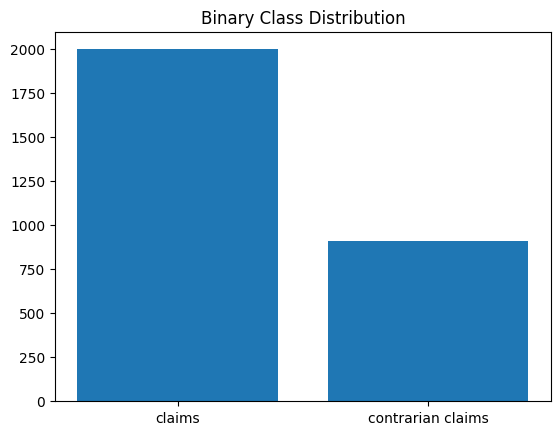

In [69]:
# Bar plot for class distribution
plt.bar(["claims","contrarian claims"], [len(testing_binary[training_binary['labels'] == 0]),len(testing_binary[training_binary['labels'] == 1])])
plt.title("Binary Class Distribution")
# show the plot
plt.show()

### Binary Logistic Regression, balanced

In [46]:
#With class weights for class imbalance.
lr = LogisticRegression(max_iter=5000, class_weight="balanced")

#Without class weights
#lr = LogisticRegression(max_iter=5000)


#Hyperparameter grid search
param_grid = [{
    "penalty": ['none', 'l1', 'l2', 'elasticnet'],
    "C": np.logspace(-4,4,20),
    "solver": ['newton-cg', 'lbfgs', 'liblinear'] 
}]

clf = RandomizedSearchCV(lr,param_grid,cv=3,n_iter=20, scoring=["precision","recall", "accuracy"], refit="accuracy")

clf.fit(X, y_binary)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=5000),
                   n_iter=20,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'penalty': ['none', 'l1', 'l2',
                                                     'elasticnet'],
                                         'solver': ['newton-cg', 'lbfgs',
                                                    'liblinear']}],
                   refit='accuracy',
                   scoring=['precision', 'recall', 'accuracy'])

In [47]:
print("best parameters: ",clf.best_params_)

best parameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.23357214690901212}


In [53]:
lr = LogisticRegression(max_iter=5000, solver="lbfgs", penalty="l2", C=0.23357214690901212, class_weight="balanced")
lr.fit(X, y_binary)

LogisticRegression(C=0.23357214690901212, class_weight='balanced',
                   max_iter=5000)

In [54]:
validation_y_binary = validation_binary["labels"]
validation_binary_predictions = lr.predict(validation_X)

In [55]:
#Using Macro-averaged as the authors use that. For comparison: 
print("Accuracy: " + str(m.accuracy_score(validation_y_binary, validation_binary_predictions)))
print("Recall: " + str(m.recall_score(validation_y_binary, validation_binary_predictions)))
print("Precision: " + str(m.precision_score(validation_y_binary, validation_binary_predictions)))
print("F1: " + str(m.f1_score(validation_y_binary, validation_binary_predictions)))

Accuracy: 0.8284069097888676
Recall: 0.7818411097099621
Precision: 0.6935123042505593
F1: 0.7350326022525192
